Number of real images: 3745
Number of deepfake images: 104201


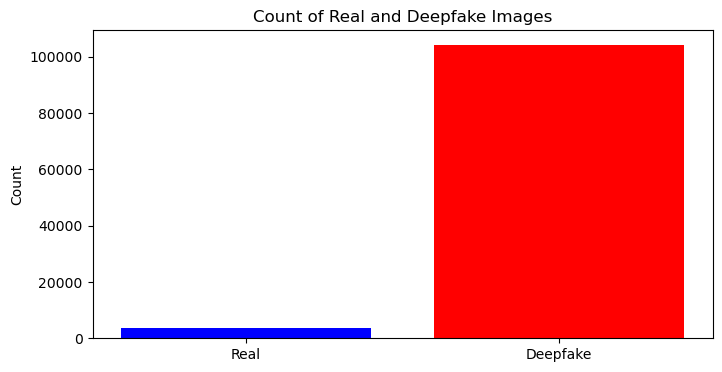

Found 86356 images belonging to 2 classes.
Found 21588 images belonging to 2 classes.


In [4]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

# Directories
parent_dir = '/Users/raisulislam/Desktop/deepfake_dataset'  # Replace with the actual path to your dataset
real_dir = os.path.join(parent_dir, 'real')
deepfake_dir = os.path.join(parent_dir, 'deepfake')

# Function to count images in a directory
def count_images(directory):
    try:
        return len(os.listdir(directory))
    except OSError as e:
        print(f"Error accessing directory {directory}: {e}")
        return 0

# Count the number of images in each category
real_count = count_images(real_dir)
deepfake_count = count_images(deepfake_dir)

# Print the counts
print(f"Number of real images: {real_count}")
print(f"Number of deepfake images: {deepfake_count}")

# Plot the counts
plt.figure(figsize=(8, 4))
plt.bar(['Real', 'Deepfake'], [real_count, deepfake_count], color=['blue', 'red'])
plt.title('Count of Real and Deepfake Images')
plt.ylabel('Count')
plt.show()

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    directory=parent_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=parent_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


In [6]:
# Input layer
input_tensor = Input(shape=(224, 224, 3))

# EfficientNetB0 model
efficient_net = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=input_tensor)
x1 = GlobalAveragePooling2D()(efficient_net.output)

# Xception model
xception = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)
x2 = GlobalAveragePooling2D()(xception.output)

# Concatenate the outputs
concatenated = Concatenate()([x1, x2])
output = Dense(1, activation='sigmoid')(concatenated)

# Define the model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
epochs = 5

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

# Save the model
model.save('/Users/raisulislam/Desktop/deepfake_detector_model.h5')

Epoch 1/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 55117s 20s/step - accuracy: 0.9805 - loss: 0.0585 - val_accuracy: 0.9679 - val_loss: 0.1263
Epoch 2/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 52707s 20s/step - accuracy: 0.9958 - loss: 0.0145 - val_accuracy: 0.9748 - val_loss: 0.0808
Epoch 3/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 57842s 21s/step - accuracy: 0.9963 - loss: 0.0118 - val_accuracy: 0.9748 - val_loss: 0.1208
Epoch 4/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 53125s 20s/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9553 - val_loss: 0.1319
Epoch 5/5
2699/2699 ━━━━━━━━━━━━━━━━━━━━ 57127s 21s/step - accuracy: 0.9976 - loss: 0.0089 - val_accuracy: 0.9748 - val_loss: 0.1750


In [14]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")

# Get true labels and predictions
y_true = validation_generator.classes
y_pred = (model.predict(validation_generator) > 0.5).astype("int32")

# Classification report
report = classification_report(y_true, y_pred, target_names=['Real', 'Deepfake'])
print(report)




675/675 ━━━━━━━━━━━━━━━━━━━━ 2632s 4s/step - accuracy: 0.9755 - loss: 0.1724
Validation Accuracy: 97.48%
675/675 ━━━━━━━━━━━━━━━━━━━━ 2638s 4s/step
              precision    recall  f1-score   support

        Real       0.97      0.99      0.98     20840
    Deepfake       0.03      0.01      0.01       748

    accuracy                           0.95     21588
   macro avg       0.50      0.50      0.50     21588
weighted avg       0.93      0.95      0.94     21588



NameError: name 'confusion_matrix' is not defined

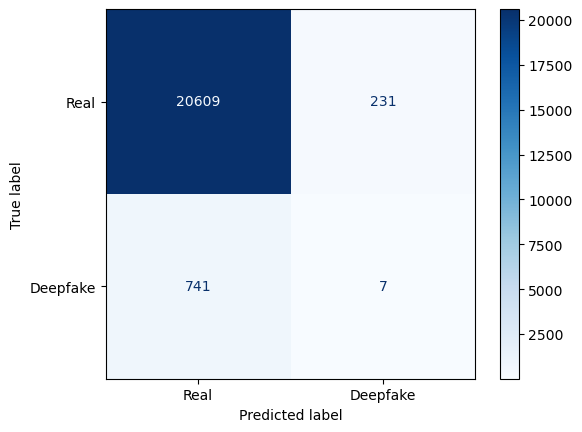

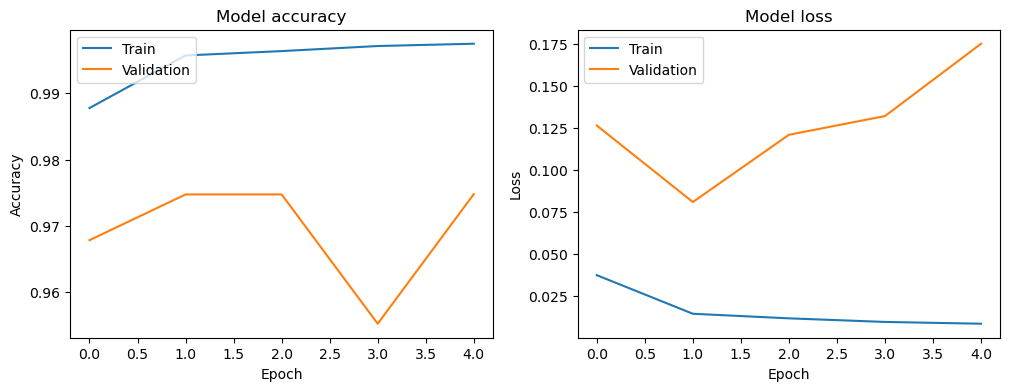

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Deepfake'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Load the model
model = load_model('/Users/raisulislam/Desktop/deepfake_detector_model.h5')

# Function to preprocess a frame
def preprocess_frame(frame):
    frame = cv2.resize(frame, (224, 224))
    frame = frame / 255.0
    frame = np.expand_dims(frame, axis=0)
    return frame

# Function to detect faces using MTCNN and preprocess them
def extract_faces(video_path):
    cap = cv2.VideoCapture(video_path)
    detector = MTCNN()
    frames = []
    faces = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detections = detector.detect_faces(rgb_frame)
        for detection in detections:
            x, y, width, height = detection['box']
            face = rgb_frame[y:y+height, x:x+width]
            faces.append(preprocess_frame(face))
        frames.append(rgb_frame)
    
    cap.release()
    return faces

# Function to predict on frames from a video
def predict_from_video(video_path):
    faces = extract_faces(video_path)
    predictions = []

    for face in faces:
        prediction = model.predict(face)[0][0]
        predictions.append(prediction)

    return np.mean(predictions)

# Upload and predict
def on_video_upload(change):
    clear_output()
    uploaded_file = change['new']
    if uploaded_file:
        video_path = list(uploaded_file.values())[0]['name']
        print(f"Uploaded file: {video_path}")
        
        avg_prediction = predict_from_video(video_path)
        label = 'Deepfake' if avg_prediction > 0.5 else 'Real'
        confidence = avg_prediction if avg_prediction > 0.5 else 1 - avg_prediction

        print(f"The video is predicted to be {label} with a confidence level of {confidence*100:.2f}%")

# Create the file upload widget
video_upload = widgets.FileUpload(accept=".mp4,.mov,.avi", multiple=False)
video_upload.observe(on_video_upload, names='value')

display(video_upload)


Epoch [1/10] Batch [0/5398] Loss: 1.7641
Epoch [1/10] Batch [100/5398] Loss: 0.0005
Epoch [1/10] Batch [200/5398] Loss: 0.1812
Epoch [1/10] Batch [300/5398] Loss: 0.0489
Epoch [1/10] Batch [400/5398] Loss: 0.0011
Epoch [1/10] Batch [500/5398] Loss: 0.0025
Epoch [1/10] Batch [600/5398] Loss: 0.0546
Epoch [1/10] Batch [700/5398] Loss: 0.0229
Epoch [1/10] Batch [800/5398] Loss: 0.0034
Epoch [1/10] Batch [900/5398] Loss: 0.0125
Epoch [1/10] Batch [1000/5398] Loss: 0.0018
Epoch [1/10] Batch [1100/5398] Loss: 0.0128
Epoch [1/10] Batch [1200/5398] Loss: 0.1125
Epoch [1/10] Batch [1300/5398] Loss: 0.1674
Epoch [1/10] Batch [1400/5398] Loss: 0.2246
Epoch [1/10] Batch [1500/5398] Loss: 0.1653
Epoch [1/10] Batch [1600/5398] Loss: 0.0023
Epoch [1/10] Batch [1700/5398] Loss: 0.0058
Epoch [1/10] Batch [1800/5398] Loss: 0.0110
Epoch [1/10] Batch [1900/5398] Loss: 0.2033
Epoch [1/10] Batch [2000/5398] Loss: 0.0009
Epoch [1/10] Batch [2100/5398] Loss: 0.0008
Epoch [1/10] Batch [2200/5398] Loss: 0.0022
